# Facts against drama – fitting and testing models

**Statistics** is the science of **learning from data** and **reducing complex structures** and trends **to succinct numerical descriptions and powerful visualisations**.

In this notebook we continue the study started [here](https://viventriglia.github.io/Fertility_and_child_mortality_rates/), creating and evaluating statistical models that allow us to describe our data.

## Imports, dataset and useful functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as pp
%matplotlib inline

In [2]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

We load the Gapminder [dataset](https://www.gapminder.org/data/), downselecting data for 1985 – why [1985](https://www.youtube.com/watch?v=JVZTP_kX5BE)?

In [3]:
gapminder = pd.read_csv('gapminder.csv')
gdata = gapminder.query('year == 1985')

Let us define functions to **plot** *data* from the dataset along with a *fit*. We do it in a generic enough way for these functions to work on arbitrary data later on.

In particular, we interrogate the object ```modelfit``` containing the results of the fit; we make use of the ```predict()``` method, which lets us reproduce model values, by computing the **predictions** of a *trained* model.

In [4]:
def sc(data):
    return 1e-6 * data.population, data.region.map({'Africa':'skyblue', 'Europe':'gold', 'America':'palegreen', 'Asia':'coral'})

def plotdata(data=gdata):
    size, colours = sc(data)
    data.plot.scatter('age5_surviving', 'babies_per_woman',
                       c=colours, s=size, edgecolor='k', linewidths=0.5, alpha=0.65)
    
def plotfit(modelfit, data=gdata):
    plotdata(data)
    size, colours = sc(data)
    pp.scatter(data.age5_surviving, modelfit.predict(data),
              c=colours, s=30, edgecolor='k', linewidths=0.5, alpha=0.8, marker='d')

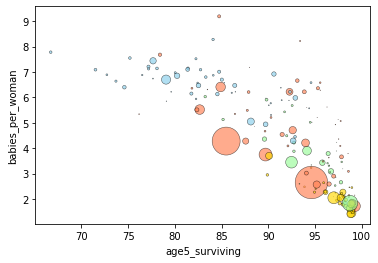

In [5]:
plotdata()

## Modelling

We explore different models of increasing complexity.
We fit models by means of the (ordinary) **least squares** (OLS) estimator, provided by the ```ols``` module in statsmodels.

### Group means
A **basic model** explains the response variable ```babies_per_woman``` depending on a costant, represented by -1, and one explanatory variable, namely the ```region``` in the world – as one can see, the intercepts simply return the means of the different regions (shown below the plot).

In [6]:
group_means_model = smf.ols(formula='babies_per_woman ~ -1 + region', data=gdata).fit()

region[Africa]     6.321321
region[America]    3.658182
region[Asia]       4.775577
region[Europe]     2.035682
dtype: float64

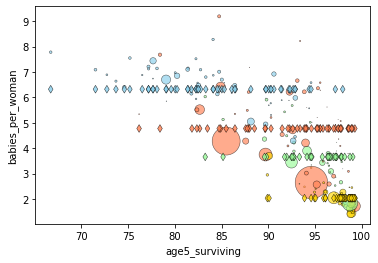

In [7]:
plotfit(group_means_model)
group_means_model.params

In [8]:
gdata.groupby('region').babies_per_woman.mean()

region
Africa     6.321321
America    3.658182
Asia       4.775577
Europe     2.035682
Name: babies_per_woman, dtype: float64

### Child survival
Let us now try something that we cannot get out of simple means; hence, we move on to a slightly more complex model, which incorporates another quantitative variable, *i.e.* ```age5_surviving```, thus accounting for the **surviving rate** at the age of five.

In [9]:
age5surv_model = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving', data=gdata).fit()

region[Africa]     18.265792
region[America]    17.085884
region[Asia]       17.864741
region[Europe]     15.872183
age5_surviving     -0.141886
dtype: float64

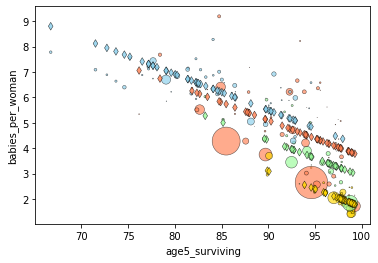

In [10]:
plotfit(age5surv_model)
age5surv_model.params

At least visually, the fit is improving; here the fit parameter ```age5_surviving``` represents the slope of the curves and it tells us that, for every additional percentage point of child survival, the number of babies per woman *decreases* by 0.14. The constant group terms are large, because they theoretically represent the number of children for a zero survival rate.

### Child survival by region

Let us now consider a slightly more general version of the previous model, which accounts for an **interaction** term: *the effect of the child survival rate depends on the region*; this is incorporated by ```age5_surviving:region```.

In [11]:
age5surv_region_model = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving:region', data=gdata).fit()

region[Africa]                    15.080914
region[America]                   27.506243
region[Asia]                      20.032483
region[Europe]                    19.884446
age5_surviving:region[Africa]     -0.104053
age5_surviving:region[America]    -0.251994
age5_surviving:region[Asia]       -0.165384
age5_surviving:region[Europe]     -0.183029
dtype: float64

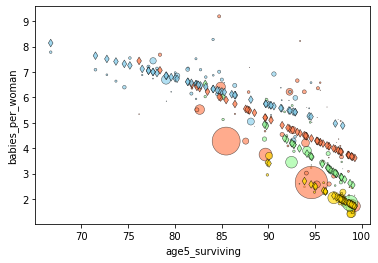

In [12]:
plotfit(age5surv_region_model)
age5surv_region_model.params

Of course, now we get a different slope for every region.

### Outliers?
India and China, represented by the large circles, seem to be outliers with respect to the fit – shall we account for it? We try to model this by introducing the ```population``` as another explanatory variable in the model.

In [13]:
age5surv_region_pop_model = smf.ols(formula='babies_per_woman ~ -1 + region + population + age5_surviving:region', data=gdata).fit()

region[Africa]                    1.513953e+01
region[America]                   2.721512e+01
region[Asia]                      2.060924e+01
region[Europe]                    1.997501e+01
population                       -2.367908e-09
age5_surviving:region[Africa]    -1.044609e-01
age5_surviving:region[America]   -2.484114e-01
age5_surviving:region[Asia]      -1.702392e-01
age5_surviving:region[Europe]    -1.835316e-01
dtype: float64

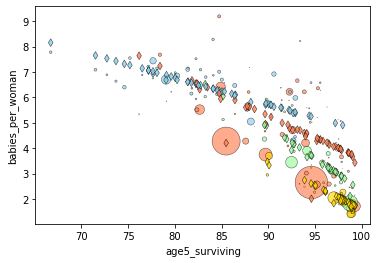

In [14]:
plotfit(age5surv_region_pop_model)
age5surv_region_pop_model.params

The predictions now do not simply lie along straight lines, because of the ```population``` explanatory variable.

## *Goodness of fit*: how good are these models?

We now wish to tell which of the previous models is *better*.
To begin with, we look at the fit results object which contains the **mean squared error** of the **residuals**.

In [15]:
for model in [group_means_model, age5surv_model, age5surv_region_model, age5surv_region_pop_model]:
    print(model.mse_resid)

1.4979520263709154
0.9423025333008324
0.8995512597945946
0.8480227300573718


The $R^2 \equiv \left(\mathrm{explained \, variance \, of \, the \, model}\right)/\left(\mathrm{total \, variance \, of \, data}\right)$ is another measure of goodness of fit, which can similarly be obtained from the fit results.

In [16]:
for model in [group_means_model, age5surv_model, age5surv_region_model, age5surv_region_pop_model]:
    print(model.rsquared)

0.636467696559659
0.7726009080146058
0.7865971252318769
0.7999775707884416


For both indicators, we see a *progress* in going towards more complicated models. However, another interesting value to consider is the $F$ **statistic**, which tests whether any of the independent variables in the regression model are significant. In other words, this is a test of *overall significance* that indicates whether the model provides a better fit to data than a model that contains *no* independent variables; indeed, too many parameters can **overfit** the data, conforming to the vagaries of the observations, but losing predictive power.

In [17]:
for model in [group_means_model, age5surv_model, age5surv_region_model, age5surv_region_pop_model]:
    print(model.fvalue)

103.88003937611687
150.34180603430977
91.622744698973
86.48787556720858


These values tell that the simple child survival model seems to hit the right spot. Finally, certain key goodness-of-fit statistics are collected in the **ANOVA** (ANalysis Of VAriance) table, which we can obtain from statsmodels.

In [18]:
sm.stats.anova_lm(group_means_model)

,df,sum_sq,mean_sq,F,PR(>F)
region,4.0,3927.702839,981.925710,655.512121,2.604302e-105
Residual,178.0,266.635461,1.497952,NaN,NaN


The **df** column gives the number of degrees of freedom – the number of region parameters, and the number of data points minus the number of parameters. The **F** column is the $F$ statistic, while the **PR(>F)** represents the $p$-value for significance of adding model terms.

Clearly, the group means, given by ```region```, explain a lot of the variance of the data, with a high $F$-value.

We now look at the ANOVA table for the child-survival model.

In [19]:
sm.stats.anova_lm(age5surv_model)

,df,sum_sq,mean_sq,F,PR(>F)
region,4.0,3927.702839,981.925710,1042.049316,8.236854e-122
age5_surviving,1.0,99.847912,99.847912,105.961630,9.003514e-20
Residual,177.0,166.787548,0.942303,NaN,NaN


Adding the ```age5_surviving``` variable explains a lot less of the variance, but the $F$-value is still pretty high.

Let us now look at the most complicated models.

In [20]:
sm.stats.anova_lm(age5surv_region_model)

,df,sum_sq,mean_sq,F,PR(>F)
region,4.0,3927.702839,981.925710,1091.572825,4.888881e-122
age5_surviving:region,4.0,110.113541,27.528385,30.602353,2.757693e-19
Residual,174.0,156.521919,0.899551,NaN,NaN


In [21]:
sm.stats.anova_lm(age5surv_region_pop_model)

,df,sum_sq,mean_sq,F,PR(>F)
region,4.0,3927.702839,981.925710,1157.900225,1.132132e-123
population,1.0,7.622832,7.622832,8.988948,3.116425e-03
age5_surviving:region,4.0,112.304696,28.076174,33.107808,1.704103e-20
Residual,173.0,146.707932,0.848023,NaN,NaN


For the most complicated models, we get even lower $F$-values for the different parameters; in particular, ```population``` shows a very low $F$-value, almost comparable to a random parameter.

**At the end of the day**, we have highlighted how overfitting is a pitfall not to be underestimated. Therefore a model of intermediate complexity (in this case, ```age5surv_model```) can be the right answer, especially when we are interested in making **reliable predictions**.

## Cross-validation

One could also think to implement a simpler strategy, known as **cross-validation**, to assess the explanatory power of a given model. This technique is used in *machine learning* to compare and validate models.

The idea is to divide the data into a **training** set, which is used to fit the model, and a **testing** set, which is used to evaluate the prediction error of the model. In other words, instead of concentrating on *in-sample* error, as we did in the previous paragraph, we look at *out-of-sample* prediction error: models need to – in some sense – *understand* something about the world.

We now build a function for cross-validation. Let us start by explaining the idea.

- Before dividing up the data, we first **shuffle** it with the ```sample()``` method (with the resulting dataset having the same lenght as the original and with no replacement); then we move by row number to split the shuffled dataset in two.

- We fit the model to the training set, *i.e.* we **train** it.

- We want the **mean squared error** (MSE). Hence, we first compute **residuals**, by applying model prediction to the testing set and subtracting observed data; then, we compute the number of **degrees of freedom**, which is the length of the testing data minus the number of parameters and the constant of the trained model; finally, we compute the MSE by its definition.

- Since the result depends on the shuffling and it can be rather noisy, we want to **repeat** this, say, $n=100$ times, and evaluate the average of the MSEs.

We should also re-define formulas of the models we used, in order to automate this procedure and run it through all the models by choosing a formula for the fit.

In [22]:
f_group_means = 'babies_per_woman ~ -1 + region'
f_age5surv = 'babies_per_woman ~ -1 + region + age5_surviving'
f_age5surv_region = 'babies_per_woman ~ -1 + region + age5_surviving:region'
f_age5surv_region_pop = 'babies_per_woman ~ -1 + region + population + age5_surviving:region'

In [23]:
def cross_validate(data, formula, response_var, n=100):
    ret = []
    
    for i in range(n):
        shuffled = data.sample(len(data))
        training, testing = shuffled.iloc[:len(data)//2], shuffled.iloc[len(data)//2:]
        trained = smf.ols(formula, data=training).fit()
        
        residuals = trained.predict(testing) - testing[response_var]
        df = len(testing) - trained.df_model - 1
        mse = np.sum(residuals**2)/df
        ret.append(mse)
        
    print(f'Mean MSE by using "{formula}": {np.mean(ret)}')

Let us try this out by looping over the models.

In [24]:
for formula in [f_group_means, f_age5surv, f_age5surv_region, f_age5surv_region_pop]:
    cross_validate(gdata, formula, 'babies_per_woman')

Mean MSE by using "babies_per_woman ~ -1 + region": 1.6248625672111336
Mean MSE by using "babies_per_woman ~ -1 + region + age5_surviving": 1.0579084760464321
Mean MSE by using "babies_per_woman ~ -1 + region + age5_surviving:region": 1.0890869956682663
Mean MSE by using "babies_per_woman ~ -1 + region + population + age5_surviving:region": 1.1560833664513905


Cross-validation confirms the verdict of analytical goodness-of-fit measures: the model of **intermediate complexity** seems to be the **best** choiche in terms of **explanatory power**.